In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
loan=pd.read_csv('../.Database/merged_cleaned_loan.csv')
loan['home_ownership'].value_counts()

home_ownership
MORTGAGE    126680
RENT        109239
OWN          21638
OTHER          176
NONE            43
ANY              1
Name: count, dtype: int64

In [3]:
# As there is only 1 observation with home_ownership = ANY,
# we will drop that observation to avoid issues with regression
loan = loan.drop(loan[loan['home_ownership'] == 'ANY'].index)

In [4]:
# Drop non-numerical columns from X
X=loan.drop(columns=['addr_state','emp_title','issue_d','loan_status','issue_d','issue_y','issue_m','title'])

# Drop annual_inc, to use log_annual_inc
X=X.drop(columns=['annual_inc'])

# Drop outcome variables from X
X=X.drop(columns=['loan_status_grouped','grade','sub_grade', 'int_rate'])

# Select outcome variable for Y
y=loan['loan_status_grouped']

def transform_emp_length(emp_length):
    if emp_length in ["< 1 year", "1 year"]:
        return "0-1 year"
    elif emp_length in ["2 years", "3 years", "4 years", "5 years"]:
        return "2-5 years"
    elif emp_length in ["6 years", "7 years", "8 years", "9 years", "10 years"]:
        return "6-10 years"
    elif emp_length == "10+ years":
        return "> 10 years"
    
X['emp_length'] = X['emp_length'].apply(transform_emp_length)

In [5]:
#Separate numerical and categorical columns
categorical_columns = ['home_ownership', 'term','purpose','emp_length']
numerical_columns = X.select_dtypes(include=['float64']).columns

# Apply OneHotEncoding to categorical columns before splitting
# dtype=int to get binary (0 or 1) values
X_encoded = pd.get_dummies(X, columns=categorical_columns, dtype=int)

# Drop the following dummies to avoid dummy variable trap
# This ensures K-1 dummies for K groups
# Dropped dummies represent the base group
# The coefficients of the regressed dummies will be relative to the base group
X_encoded = X_encoded.drop(columns=['home_ownership_MORTGAGE','term_ 36 months','purpose_car','emp_length_0-1 year'])

In [6]:
# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure the train and test sets have the same structure (dummies already handled)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply scaling to numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [7]:
# Dummies without drop_first
df_dummies_all = pd.get_dummies(X, columns=categorical_columns, drop_first=False, dtype=int)
print("Without drop_first:\n", df_dummies_all.columns)

# Dummies with drop_first
df_dummies_dropped = pd.get_dummies(X, columns=categorical_columns, drop_first=True, dtype=int)
print("\nWith drop_first:\n", df_dummies_dropped.columns)

Without drop_first:
 Index(['delinq_2yrs', 'dti', 'funded_amnt', 'inq_last_6mths', 'installment',
       'loan_amnt', 'mths_since_last_delinq', 'pub_rec', 'total_acc',
       'total_pymnt', 'acc_now_delinq', 'log_annual_inc',
       'Effective Federal Funds Rate', 'state_unemployment',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'term_ 36 months', 'term_ 60 months', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'emp_length_0-1 year',
       'emp_length_2-5 years', 'emp_length_6-10 years',
       'emp_length_> 10 years'],
      dtype='object')

With drop_first:
 Index(['delinq_2yrs', 'dti', 'funded_a

In [8]:
X['home_ownership'].value_counts()

home_ownership
MORTGAGE    126680
RENT        109239
OWN          21638
OTHER          176
NONE            43
Name: count, dtype: int64

In [9]:
X['term'].value_counts()

term
36 months    197634
60 months     60142
Name: count, dtype: int64

In [10]:
X['purpose'].value_counts()

purpose
debt_consolidation    151937
credit_card            50389
home_improvement       15080
other                  14555
major_purchase          6339
small_business          4985
car                     3637
medical                 2875
moving                  2058
wedding                 1994
house                   1697
vacation                1554
educational              413
renewable_energy         263
Name: count, dtype: int64

In [11]:
X['emp_length'].value_counts()

emp_length
2-5 years     82862
> 10 years    81247
6-10 years    53152
0-1 year      40515
Name: count, dtype: int64

In [12]:
# Drop rows with NaN values in X_train or y_train
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Ensure y_train matches X_train

In [13]:
# Checking for higher collinear predictors
#from statsmodels.stats.outliers_influence import variance_inflation_factor
#vif_data = pd.DataFrame()
#vif_data["feature"] = X_train.columns
#vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
#print(vif_data)

# Drop highly collinear predictors from X_train and X_test
X_train = X_train.drop(columns=['funded_amnt','loan_amnt','total_pymnt','installment'])
X_test = X_test.drop(columns=['funded_amnt','loan_amnt','total_pymnt','installment'])

In [14]:
# The data has about 5 times as many repaid loans (0) as defaulted loans (1)
# Such class balance issues can skew predictions greatly
# We can use SMOTE (Synthetic Minority Over-sampling Technique) to oversample the minority class

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [15]:
# Using statsmodels library to run Logit Regression

# Add a constant to the independent variables
X_train_with_const = sm.add_constant(X_train)
X_test_with_const = sm.add_constant(X_test)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_with_const)

# Fit the model and obtain the result object
result = logit_model.fit(maxiter=1000)

# Print the summary of the logistic regression results
print(result.summary())

# Print odds ratios 
odds_ratios = np.exp(result.params)
print('\nOdds Ratios\n',odds_ratios)

Optimization terminated successfully.
         Current function value: 0.636582
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     loan_status_grouped   No. Observations:               322574
Model:                           Logit   Df Residuals:                   322542
Method:                            MLE   Df Model:                           31
Date:                 Sat, 26 Oct 2024   Pseudo R-squ.:                 0.08161
Time:                         17:12:53   Log-Likelihood:            -2.0534e+05
converged:                        True   LL-Null:                   -2.2359e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            1.7777      0.024     72.691   

Accuracy: 0.73 

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.84      0.83     40423
         1.0       0.37      0.34      0.35     11133

    accuracy                           0.73     51556
   macro avg       0.59      0.59      0.59     51556
weighted avg       0.72      0.73      0.73     51556



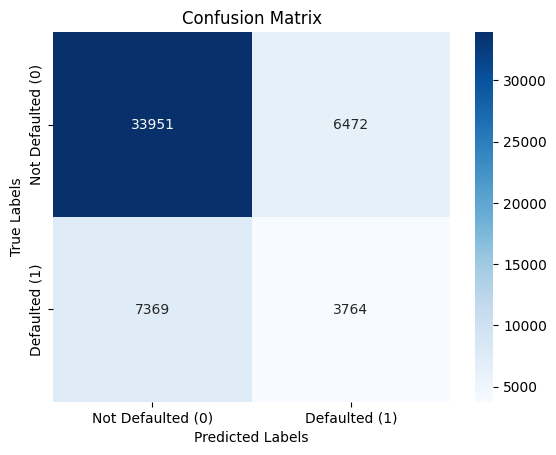

In [16]:
# Make predictions
threshold = 0.6
predicted_probs = result.predict(X_test_with_const)  # Predict probabilities
predicted_classes = np.where(predicted_probs < threshold, 0, 1)

# Generate evaluation metrics
accuracy = accuracy_score(y_test, predicted_classes)
class_report = classification_report(y_test, predicted_classes)
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Print the accuracy score and classication report
print(f'Accuracy: {accuracy:.2f}',"\n")
print("Classification Report:\n", class_report)

# Plot confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['Not Defaulted (0)', 'Defaulted (1)'], yticklabels=['Not Defaulted (0)', 'Defaulted (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

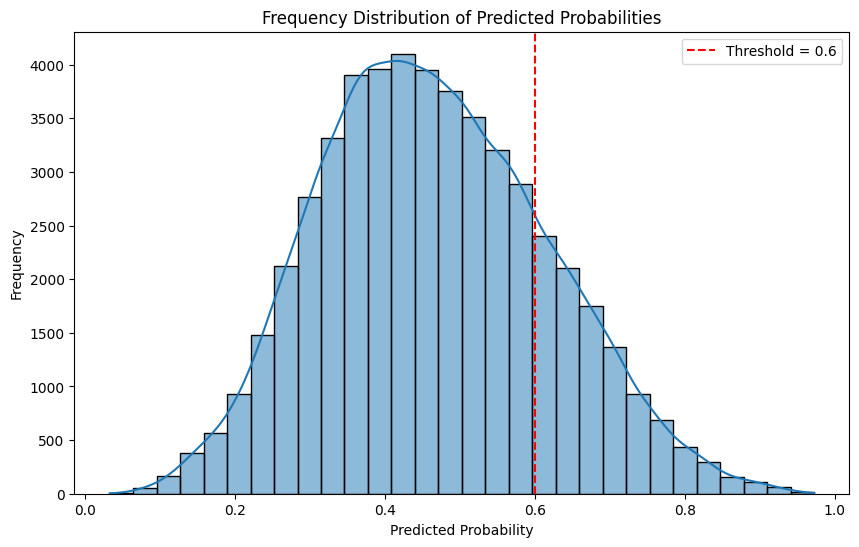

In [17]:
# Don't keep this
# Just to show how weird the predictions from statsmodels logit regression are

plt.figure(figsize=(10, 6))
sns.histplot(predicted_probs, bins=30, kde=True)  # Use KDE for a smoother curve
plt.title('Frequency Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold = {}'.format(threshold))
plt.legend()
plt.show()

Logit model predictions using sklearn

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



# Create a logistic regression model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Generate evaluation metrics
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}',"\n") 
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the accuracy score and classication report
print(f'Accuracy: {accuracy:.2f}',"\n")
print("Classification Report:\n", class_report)

# Plot confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['Not Defaulted (0)', 'Defaulted (1)'], yticklabels=['Not Defaulted (0)', 'Defaulted (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values